In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
def get_titeseq_replicate_df(replicate_number='1'):

    data_df_full = pd.read_csv(f'data/replicate_{replicate_number}.csv',index_col=[0])
    y_cols = list(data_df_full.columns[14:58])
    cols = y_cols.copy()
    # Currently concatenating CDR1-H and CDR3-H sequencnes. Not sure if correct.
    data_df_full['x'] = (data_df_full['CDR1H_AA']+data_df_full['CDR3H_AA']).values
    cols.insert(0,'x')
    data_df = data_df_full[cols].copy()
    
    return data_df
    

In [3]:
replicate_1_df = get_titeseq_replicate_df('1')
replicate_2_df = get_titeseq_replicate_df('2')
replicate_3_df = get_titeseq_replicate_df('3')

data_df = replicate_1_df.append(replicate_2_df, ignore_index=True).append(replicate_3_df, ignore_index=True).reset_index(drop=True).copy()

In [4]:
data_df_full_rep_1 = pd.read_csv(f'data/replicate_1.csv',index_col=[0])
y_cols = list(data_df_full_rep_1.columns[14:58])
X = data_df['x']
y = data_df[y_cols]

In [5]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=20, Y=44


In [7]:
# instantiate gpmap object
gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
                                              alphabet=alphabet,
                                              number_latent_nodes=2)



In [8]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [9]:
print(N_y)

fluorescein0bin0          15885950
fluorescein0bin1            845949
fluorescein0bin2          14646947
fluorescein0bin3            480168
fluorescein10^-5.5bin0     4938811
fluorescein10^-5.5bin1     3558812
fluorescein10^-5.5bin2     7335952
fluorescein10^-5.5bin3     7306329
fluorescein10^-5bin0      12323072
fluorescein10^-5bin1       1386792
fluorescein10^-5bin2      14067051
fluorescein10^-5bin3      14797633
fluorescein10^-6.5bin0     7778006
fluorescein10^-6.5bin1     1084990
fluorescein10^-6.5bin2     6335215
fluorescein10^-6.5bin3    14460000
fluorescein10^-6bin0       1870048
fluorescein10^-6bin1       6027256
fluorescein10^-6bin2       2933272
fluorescein10^-6bin3      10097157
fluorescein10^-7.5bin0     3535644
fluorescein10^-7.5bin1     1078611
fluorescein10^-7.5bin2     3070755
fluorescein10^-7.5bin3     3000078
fluorescein10^-7bin0       3645702
fluorescein10^-7bin1        565856
fluorescein10^-7bin2       8837515
fluorescein10^-7bin3       2756860
fluorescein10^-8.5bi

#### I approximated these values from Fig 3's script

In [10]:
bin_vals_16_4_15 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.9683536647430646],
[2.96837636283699, 3.6663288893768895],
[3.6675170811229103, np.log10(3e4)]])

#April 19 gates
bin_vals_16_4_19 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.85027248745035],
[2.8650326346119392, 3.474446976276228],
[3.4849588153986915, np.log10(1e5)]])

#April 21 gates
bin_vals_16_4_21 = np.array([[1.4775788014225415,2.200826012340419],
[2.216443456408671,2.8355123402887603],
[2.8355123402887603,3.474446976276228],
[3.4849588153986915,np.log10(3e4)]])

aff_gates = [bin_vals_16_4_15, bin_vals_16_4_19, bin_vals_16_4_21]

In [11]:
np.mean(np.array(aff_gates),axis=0)

array([[1.4775788 , 2.23034631],
       [2.23612365, 2.88471283],
       [2.88964045, 3.53840761],
       [3.54581157, 4.65141417]])

In [12]:
#bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds = np.mean(np.array(aff_gates),axis=0)
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,1.477579,2.230346
1,2.236124,2.884713
2,2.889640,3.538408
3,3.545812,4.651414


In [13]:
mu_neg = 100
mu_pos = 1000

sigma_neg = 100
sigma_pos = 200

# mu_neg = 200
# mu_pos = 9000

# sigma_neg = 100
# sigma_pos = 1000

# mu_neg = np.log(200)
# mu_pos = np.log(9000)

# sigma_neg = 1.0
# sigma_pos = 1.0

In [14]:
mu_neg, sigma_neg

(100, 100)

In [15]:
f_y_upper_bounds

array([2.23034631, 2.88471283, 3.53840761, 4.65141417])

In [16]:
#np.arange(10**(-13),10**(-6),10**(-12))
cs = [0,10**(-9.5),
     10**(-9),10**(-8.5),
     10**(-8),10**(-7.5),
     10**(-7),10**(-6.5),
     10**(-6),10**(-5.5),
     10**(-5),]

# cs = np.arange(0.1,1,0.085)
#cs = np.array(cs)*(10**9)

In [17]:
TiteSeq_mp_list = [mavenn.measurement_process_layers.TiteSeqMP(N_y=N_y[4*mp_idx:4*mp_idx+4],
                                                         c=cs[mp_idx],
                                                         Y=4,
                                                         mu_pos=mu_pos,
                                                         sigma_pos=sigma_pos,
                                                         mu_neg=mu_neg,
                                                         sigma_neg=sigma_neg,
                                                         f_y_lower_bounds=f_y_lower_bounds,
                                                         f_y_upper_bounds=f_y_upper_bounds,
                                                         info_for_layers_dict={'H_y_norm':0},
                                                         eta=1e-5,)
           for mp_idx in range(len(y_cols)//4)
          ]

In [18]:
len(TiteSeq_mp_list)

11

In [19]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=TiteSeq_mp_list)

2022-08-03 23:55:05.356292: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
#model.model.summary()

In [21]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,                                                        
                      ],

               shuffle=False)

N = 10,487 observations set as training data.
Using 19.9% for validation.
Time to set data: 0.386 sec.


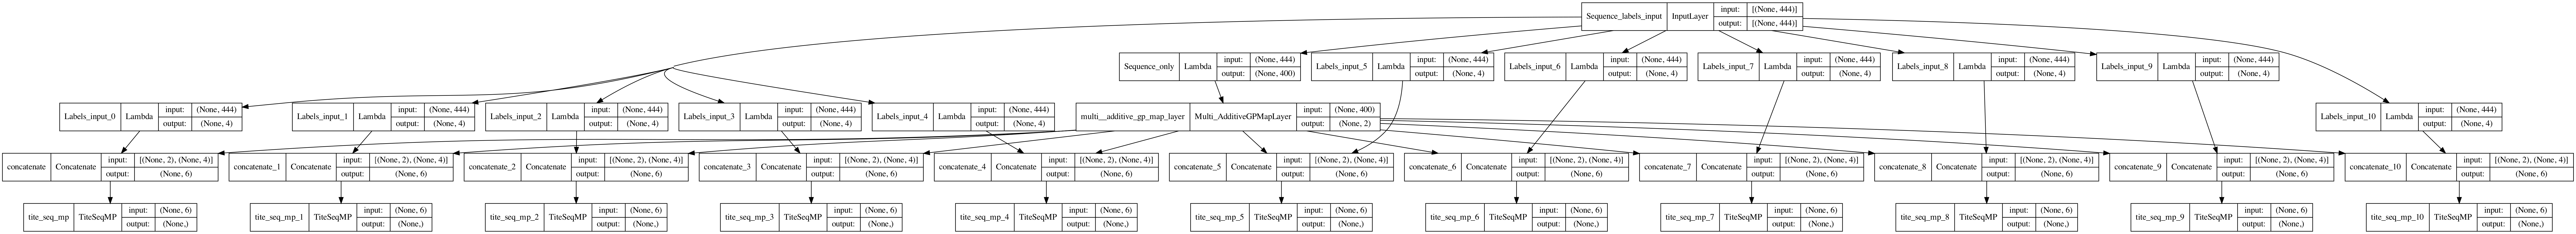

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200,to_file='pngs/Titeseq_MP/titeseq16_TSMP.png')


In [23]:

# Fit model to data
model.fit(learning_rate=.00001,
          epochs=30,
          batch_size=200,
          try_tqdm = False,
          early_stopping=False,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/30
42/42 [==============================] - 10s 42ms/step - loss: 7355989.0000 - tite_seq_mp_loss: 552087.0000 - tite_seq_mp_1_loss: 636536.9375 - tite_seq_mp_2_loss: 1049931.3750 - tite_seq_mp_3_loss: 698071.6250 - tite_seq_mp_4_loss: 512339.4688 - tite_seq_mp_5_loss: 280279.5312 - tite_seq_mp_6_loss: 355533.0000 - tite_seq_mp_7_loss: 923657.9375 - tite_seq_mp_8_loss: 633027.3125 - tite_seq_mp_9_loss: 909940.1875 - tite_seq_mp_10_loss: 804584.0625 - I_var: -0.2896 - val_loss: 4368628.5000 - val_tite_seq_mp_loss: 337102.0938 - val_tite_seq_mp_1_loss: 387080.6875 - val_tite_seq_mp_2_loss: 627535.6875 - val_tite_seq_mp_3_loss: 437200.8438 - val_tite_seq_mp_4_loss: 325093.9688 - val_tite_seq_mp_5_loss: 194127.0469 - val_tite_seq_mp_6_loss: 199817.8750 - val_tite_seq_mp_7_loss: 508383.8438 - val_tite_seq_mp_8_loss: 327322.5000 - val_tite_seq_mp_9_loss: 519148.8750 - val_tite_seq_mp_10_loss: 505815.0625 - val_I_var: -0.3185
Epoch 2/30
42/42 [==============================] - 0s 7ms/

Epoch 10/30
42/42 [==============================] - 0s 6ms/step - loss: 7355965.5000 - tite_seq_mp_loss: 552083.5000 - tite_seq_mp_1_loss: 636539.5625 - tite_seq_mp_2_loss: 1049927.0000 - tite_seq_mp_3_loss: 698069.2500 - tite_seq_mp_4_loss: 512338.7500 - tite_seq_mp_5_loss: 280279.8125 - tite_seq_mp_6_loss: 355532.6562 - tite_seq_mp_7_loss: 923662.9375 - tite_seq_mp_8_loss: 633024.5625 - tite_seq_mp_9_loss: 909935.1875 - tite_seq_mp_10_loss: 804573.8750 - I_var: -0.2934 - val_loss: 4368628.5000 - val_tite_seq_mp_loss: 337102.0938 - val_tite_seq_mp_1_loss: 387080.6875 - val_tite_seq_mp_2_loss: 627535.6875 - val_tite_seq_mp_3_loss: 437200.8438 - val_tite_seq_mp_4_loss: 325093.9688 - val_tite_seq_mp_5_loss: 194127.0469 - val_tite_seq_mp_6_loss: 199817.8750 - val_tite_seq_mp_7_loss: 508383.8438 - val_tite_seq_mp_8_loss: 327322.5000 - val_tite_seq_mp_9_loss: 519148.8750 - val_tite_seq_mp_10_loss: 505815.0625 - val_I_var: -0.3185
Epoch 11/30
42/42 [==============================] - 0s 6ms/

Epoch 19/30
42/42 [==============================] - 0s 6ms/step - loss: 7355973.0000 - tite_seq_mp_loss: 552085.3750 - tite_seq_mp_1_loss: 636536.8750 - tite_seq_mp_2_loss: 1049926.6250 - tite_seq_mp_3_loss: 698072.2500 - tite_seq_mp_4_loss: 512336.3125 - tite_seq_mp_5_loss: 280278.5938 - tite_seq_mp_6_loss: 355534.0625 - tite_seq_mp_7_loss: 923662.3750 - tite_seq_mp_8_loss: 633026.7500 - tite_seq_mp_9_loss: 909934.1875 - tite_seq_mp_10_loss: 804580.4375 - I_var: -0.2777 - val_loss: 4368628.5000 - val_tite_seq_mp_loss: 337102.0938 - val_tite_seq_mp_1_loss: 387080.6875 - val_tite_seq_mp_2_loss: 627535.6875 - val_tite_seq_mp_3_loss: 437200.8438 - val_tite_seq_mp_4_loss: 325093.9688 - val_tite_seq_mp_5_loss: 194127.0469 - val_tite_seq_mp_6_loss: 199817.8750 - val_tite_seq_mp_7_loss: 508383.8438 - val_tite_seq_mp_8_loss: 327322.5000 - val_tite_seq_mp_9_loss: 519148.8750 - val_tite_seq_mp_10_loss: 505815.0625 - val_I_var: -0.3185
Epoch 20/30
42/42 [==============================] - 0s 5ms/

Epoch 28/30
42/42 [==============================] - 0s 7ms/step - loss: 7356006.0000 - tite_seq_mp_loss: 552084.4375 - tite_seq_mp_1_loss: 636540.4375 - tite_seq_mp_2_loss: 1049932.2500 - tite_seq_mp_3_loss: 698076.5625 - tite_seq_mp_4_loss: 512338.0938 - tite_seq_mp_5_loss: 280280.9062 - tite_seq_mp_6_loss: 355536.8438 - tite_seq_mp_7_loss: 923671.5625 - tite_seq_mp_8_loss: 633027.5625 - tite_seq_mp_9_loss: 909937.7500 - tite_seq_mp_10_loss: 804580.5000 - I_var: -0.2826 - val_loss: 4368628.5000 - val_tite_seq_mp_loss: 337102.0938 - val_tite_seq_mp_1_loss: 387080.6875 - val_tite_seq_mp_2_loss: 627535.6875 - val_tite_seq_mp_3_loss: 437200.8438 - val_tite_seq_mp_4_loss: 325093.9688 - val_tite_seq_mp_5_loss: 194127.0469 - val_tite_seq_mp_6_loss: 199817.8750 - val_tite_seq_mp_7_loss: 508383.8438 - val_tite_seq_mp_8_loss: 327322.5000 - val_tite_seq_mp_9_loss: 519148.8750 - val_tite_seq_mp_10_loss: 505815.0625 - val_I_var: -0.3185
Epoch 29/30
42/42 [==============================] - 0s 6ms/

On test data:


Text(0.5, 1.0, 'training hisotry')

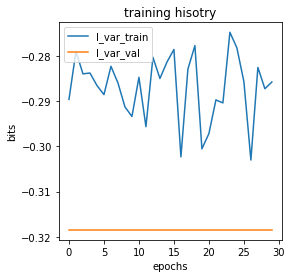

In [24]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

In [25]:
#theta = np.squeeze(gpmap.weights[1].numpy())
#theta_df = pd.DataFrame(theta,columns=model.alphabet)

theta_0 = np.squeeze(gpmap.weights[1].numpy())[0]
theta_0_df = pd.DataFrame(theta_0,columns=model.alphabet)

theta_1 = np.squeeze(gpmap.weights[1].numpy())[1]
theta_1_df = pd.DataFrame(theta_1,columns=model.alphabet)

In [26]:
#phi = gpmap.x_to_phi(x_test)

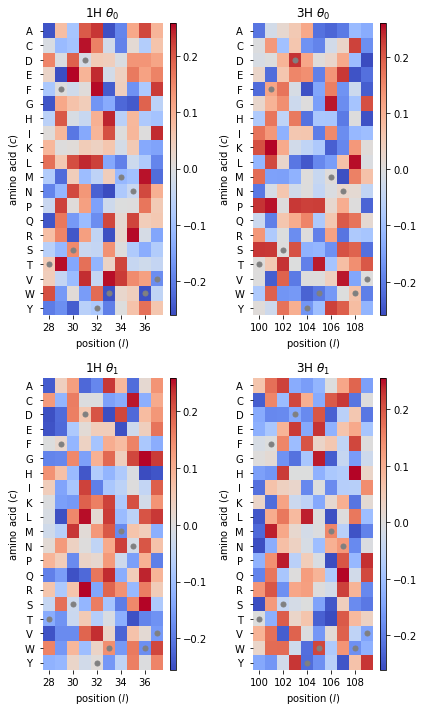

In [27]:
fig, axs = plt.subplots(2,2, figsize=(6,10))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0,0],
                                values=theta_0_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H $\\theta_{0}$')

heatmap_ax, cb = mavenn.heatmap(ax=axs[0,1],
                                values=theta_0_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H $\\theta_{0}$')

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[1,0],
                                values=theta_1_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H $\\theta_{1}$')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1,1],
                                values=theta_1_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H $\\theta_{1}$')

fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/GP_map.png',dpi=200,bbox_inches='tight')

In [29]:
# Create grid in phi space
phi_lim = [-5, 5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = sortseq_mp.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = sortseq_mp.p_of_y_given_phi(y_all, phi_grid)


# Create figure with two panels
fig, ax = plt.subplots(1,1,figsize=[6,6])

# Right panel: draw measurement process as heatmap
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('Sort-seq measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
